<h1>Astro 283 Homework 5</h1>
Bijan Pourhamzeh

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import iv
import scipy.stats
from csv import reader
from __future__ import print_function

<h3>Random Sampling</h3>

Here we sample from a distribution given by the equation

$$
p(x\mid \alpha,\beta) = \left\{
\begin{array}{ll}
\alpha^{-1}\exp\left(-\frac{x+\beta}{\alpha}\right)I_0\left(\frac{2\sqrt{x\beta}}{\alpha}\right) & \quad x\geq 0\\
0 & \quad\text{otherwise}
\end{array}
\right.
$$

This is done by the rejection method. Choosing $(\alpha,\beta)=(6.9,42.0)$, we only draw from $x<250$ since the distribution function is sufficiently small for larger values.

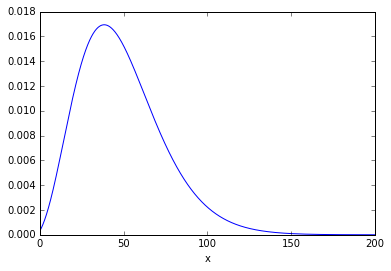

In [2]:
#Choose parameters and plot to see what it looks like

alpha = 6.9
beta = 42.0
x = np.arange(0,200,0.1)
pdf = lambda x: (1/alpha)*np.exp(-(x+beta)/alpha)*iv(0,2*np.sqrt(x*beta)/alpha)
plt.plot(x,pdf(x),'b-')
plt.xlabel('x')

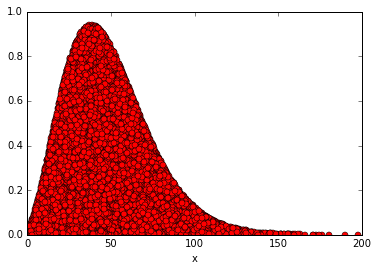

In [3]:
#Do rejection method with uniform sampling and plot to see if it looks right

iters = 100000
hi = 250
M = 4.5
x = []
u = []
for n in range(0,iters):
    u_rand = np.random.rand()
    x_rand = np.random.uniform(0,hi)
    if u_rand < pdf(x_rand)/(M/hi):
        u += [u_rand]
        x += [x_rand]
        
plt.plot(x,u,'ro')
plt.xlabel('x')

In [4]:
#Write to file. Skip first two because I'm crazy.

N = 50
f = open('astro283_hw5_bijan.txt','w')
#f.write('(alpha,beta) = (6.9, 42.0)\n\n')

for i in range(0,N+2):
    if i < 2:
        continue
    else:
        index = np.random.randint(0,M)
        f.write(str(x[index])+'\n')
        
f.close()

In [5]:
#Read in data for problem 2

data = reader(open('hw5prob2-data.txt','rt'), delimiter = ' ')
x_dat = []
y_dat = []
sig = []
for row in data:
    if row[0] == 'x':
        continue
    else:
        x_dat.append(float(row[0]))
        y_dat.append(float(row[1]))
        sig.append(float(row[2]))

<h3>Comparing quadratic and cubic polynomial fits</h3>

To compare the relative fit of a quadratic and cubic polynomial to the data, we compute the ratio

\begin{eqnarray}
\frac{P\left(x^2\mid\{D\}\right)}{P\left(x^3\mid\{D\}\right)} &=& \frac{\int p\left(x^2,\{\lambda\}\mid\{D\}\right)d^3\lambda}{\int p\left(x^3,\{\eta\}\mid\{D\}\right) d^4\eta}\\
&=& \frac{\int P\left(\{D\}\mid x^2,\{\lambda\}\right)p\left(x^2,\{\lambda\}\right) d^3\lambda}{\int P\left(\{D\}\mid x^3,\{\eta\}\right)p\left(x^3,\{\eta\}\right) d^4\eta}\\
\end{eqnarray}

where we use marginalization and Baye's rule. Note that the denominator coming from Baye's rule cancels out. We assume that the priors $P\left(x^2,\{\lambda\}\right)$ and $P\left(x^3,\{\eta\}\right)$ are uniform, so from the product rule,

\begin{eqnarray}
\frac{p\left(x^2,\{\lambda\}\right)}{p\left(x^3,\{\eta\}\right)} &=& \frac{\prod_{i=1}^3\frac{1}{\lambda_i^\text{max}-\lambda_i^\text{min}}}{\prod_{i=1}^4\frac{1}{\eta_i^\text{max}-\eta_i^\text{min}}}
\end{eqnarray}

Since the errors are independent and Gaussian-distributed, the likelihood functions are given by

\begin{eqnarray}
P\left(\{D\}\mid x^n,A\right) &=& \prod_{i=1}^N\frac{1}{\sqrt{2\pi\sigma^2_i}}\exp\left[-\frac{(y_i-f_n(x_i,A))^2}{2\sigma_i^2}\right]\\
&=& \left(\prod_{i=1}^N\frac{1}{\sqrt{2\pi\sigma^2_i}}\right)\exp\left(-\frac{\chi_0^2}{2}\right)\exp\left(-\frac{\chi^2-\chi_0^2}{2}\right)
\end{eqnarray}

where $A$ is a generic set of parameters and $N$ is the number of data points. In the second line, we write it in a form that is more useful computationally, where

\begin{eqnarray}
\chi^2 &=& \sum_{i=1}^N\frac{(y_i-f_n(x_i,A))^2}{\sigma_i^2}\\
\chi^2_0 &=& \sum_{i=1}^N\frac{(y_i-f_n(x_i,A_0))^2}{\sigma_i^2}
\end{eqnarray}

and $A_0$ is the set of best fit parameters. For the fitting functions, we have

\begin{eqnarray}
f_2(x_i,\{\lambda\}) &=& \lambda_2x^2_i+\lambda_1x_i+\lambda_0\\
f_3(x_i,\{\eta\}) &=& \eta_3x^3_i+\eta_2x^2_i+\eta_1x_i+\eta_0
\end{eqnarray}

Plugging this all in, setting $\lambda_i^\text{max}=\eta_i^\text{max}=500$, setting $\lambda_i^\text{min}=\eta_i^\text{min}=-500$, and integrating $\lambda_i,\eta_i$ from the max and min values, we get an estimate of the ratio written above.

The integration is done using a Monte Carlo rejection method. The points are sampled from the Gaussians 

\begin{eqnarray}
g_2\left(\{\lambda\}\right) &=& \frac{1}{\sqrt{(2\pi)^2\det\Sigma_2}}\exp\left[-\frac{1}{2}(\lambda-\lambda_0)^T\Sigma_2^{-1}(\lambda-\lambda_0)\right]\\
g_3\left(\{\eta\}\right) &=& \frac{1}{\sqrt{(2\pi)^3\det\Sigma_3}}\exp\left[-\frac{1}{2}(\eta-\eta_0)^T\Sigma_3^{-1}(\eta-\eta_0)\right]
\end{eqnarray}

where $\lambda_0,\Sigma_2,\eta_0,\Sigma_3$ are the best fit parameters and errors. We use the rejection method to obtain samples from a uniform distribution.

From the result, we see that the quadratic fit is better since

$$
\frac{P\left(x^2\mid\{D\}\right)}{P\left(x^3\mid\{D\}\right)} \sim 10^5
$$

In [6]:
#Define functions for integration

def poly(x,n,L):
    if n+1 != len(L):
        return "Error: need ", n+1, " parameters!"        
    out = 0
    for k in range(0,n+1):
        out += L[n-k]*np.power(x,n-k)
    return out

def chi_sq(x, y, sigma, fun, *params):
    out = 0
    for i in range(0,len(x)):
        out += (y[i] - fun(x[i], *params))**2/(sigma[i]**2)
    return out

def gaussian_f(x, x0, cov):
    if type(cov) is not np.matrix:
        cov = np.matrix(cov)
    vec = np.matrix(x - x0)
    n_p = len(vec)
    return float(1/(np.sqrt((2*np.pi)**n_p*np.linalg.det(cov)))*np.exp(-0.5*vec*cov.I*vec.T))

In [7]:
#obtain fit parameters

from scipy.optimize import curve_fit

f_3 = lambda x,L3,L2,L1,L0: poly(x,3,[L3,L2,L1,L0])
f_2 = lambda x,L2,L1,L0: poly(x,2,[L2,L1,L0])

popt_3, pcov_3 = curve_fit(f_3, x_dat, y_dat, p0=[1,1,1,1], sigma=sig)
popt_2, pcov_2 = curve_fit(f_2, x_dat, y_dat, p0=[1,1,1], sigma=sig)

print(popt_3)
print(popt_2)

[ 1.026528    2.29234304 -0.43681756  0.03046583]
[ 3.82346153 -0.10409732  0.07506906]


In [10]:
#Do integration by Gaussian sampling around best fit. Sampling is done by rejection method.

int_N = 10000
b = 500
a = -500

int_sum_3 = 0.
for k in range(0,int_N):
    
    u_rand = np.random.rand()
    x_gau = [np.random.uniform(popt_3[0]-2,popt_3[0]+2), 
             np.random.uniform(popt_3[1]-.5,popt_3[1]+.5), 
             np.random.uniform(popt_3[2]-.05,popt_3[2]+.05), 
             np.random.uniform(popt_3[3]-.005,popt_3[3]+.005)]
    while u_rand > gaussian_f(x_gau,popt_3,pcov_3)/gaussian_f(popt_3,popt_3,pcov_3):
        u_rand = np.random.rand()
        x_gau = [np.random.uniform(popt_3[0]-2,popt_3[0]+2), 
                 np.random.uniform(popt_3[1]-.5,popt_3[1]+.5), 
                 np.random.uniform(popt_3[2]-.05,popt_3[2]+.05), 
                 np.random.uniform(popt_3[3]-.005,popt_3[3]+.005)]
           
    int_sum_3 += np.exp(-0.5*(chi_sq(x_dat,y_dat,sig,f_3,*x_gau)
                              -chi_sq(x_dat,y_dat,sig,f_3,*popt_3)))/gaussian_f(x_gau,popt_3,pcov_3)

int_sum_3 = (1/float(int_N))*int_sum_3
#print(int_sum_3)

int_sum_2 = 0.
for k in range(0,int_N):
    
    u_rand = np.random.rand()
    x_gau = [np.random.uniform(popt_2[0]-2,popt_2[0]+2), 
             np.random.uniform(popt_2[1]-.5,popt_2[1]+.5), 
             np.random.uniform(popt_2[2]-.05,popt_2[2]+.05)]
    while u_rand > gaussian_f(x_gau,popt_2,pcov_2)/gaussian_f(popt_2,popt_2,pcov_2):
        u_rand = np.random.rand()
        x_gau = [np.random.uniform(popt_2[0]-2,popt_2[0]+2), 
                 np.random.uniform(popt_2[1]-.5,popt_2[1]+.5), 
                 np.random.uniform(popt_2[2]-.05,popt_2[2]+.05)]
           
    int_sum_2 += np.exp(-0.5*(chi_sq(x_dat,y_dat,sig,f_2,*x_gau)
                              -chi_sq(x_dat,y_dat,sig,f_2,*popt_2)))/gaussian_f(x_gau,popt_2,pcov_2)

int_sum_2 = (1/float(int_N))*int_sum_2
#print(int_sum_2)

#Compute ratio
ratio = (int_sum_2/int_sum_3)*np.exp(-0.5*(chi_sq(x_dat,y_dat,sig,f_2,*popt_2)
                              -chi_sq(x_dat,y_dat,sig,f_3,*popt_3)))*(b-a)
print(ratio)

11133.4034744


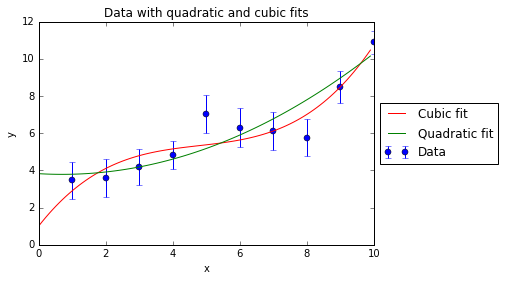

In [9]:
#Plot fits for fun

t=np.arange(0,10,.1)
a3, a2, a1, a0 = popt_3
b2, b1, a0 = popt_2
plt.errorbar(x_dat, y_dat, yerr=sig, fmt='o', label='Data')
fit_3, = plt.plot(t, f_3(t, *popt_3), 'r-', label='Cubic fit')
fit_2, = plt.plot(t, f_2(t, *popt_2), 'g-', label='Quadratic fit')
plt.ylabel('y')
plt.xlabel('x')
plt.title('Data with quadratic and cubic fits')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))